In [1]:
import os
import random

import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer

from VectorSpaceModel import *
from KNNClassifier import *

In [2]:
# define constants
PATH = "./20news-18828/"

In [3]:
# generate file path of training set and testing set
subdirs = os.listdir(PATH)
training_set_fns = []
test_set_fns = []
splitting_pos = 500
for dir_ in subdirs:
    files = os.listdir(PATH+dir_)
    training_set_fns.extend(os.path.join(dir_, fn) for fn in files[:splitting_pos])
    test_set_fns.extend(os.path.join(dir_, fn) for fn in files[splitting_pos:])

In [4]:
# read documents of training set
training_docs = []
for fn in training_set_fns:
    with open(PATH+fn, encoding='latin1') as f:
        training_docs.append(f.read())

In [5]:
# preprocess training docs
stop_words = set(stopwords.words('english'))
def filter_stop_words(doc):
    return filter(lambda w: w not in stop_words, doc)

tokenized_docs = []
tokenizer = RegexpTokenizer(r'\w+')
stemmer = SnowballStemmer("english", ignore_stopwords=True)
for doc in training_docs:
    word_tokens = tokenizer.tokenize(doc) # Tokenization
    word_stems = [stemmer.stem(w.lower()) for w in word_tokens] # Stemming/normalization
    word_without_stopwords = filter_stop_words(word_stems) # Stopword/controlled vocabulary filtering
    tokenized_docs.append(word_without_stopwords)

In [6]:
# get the VSM representation of each training document
vsms = []
for doc in tokenized_docs:
    vsm = VectorSpaceModel(doc)
    VectorSpaceModel.accumulateDocumentFrequency(vsm.getTerms())
    vsms.append(vsm)

VectorSpaceModel.calIDF()
for vsm in vsms:
    vsm.calWeight(TF_Scale.MAXIMUM)
    vsm.normalize()

In [7]:
len(vsms)

10000

In [8]:
# select some testing data
N = len(test_set_fns)
sample_num = 200
test_indices = random.sample(range(N), k=sample_num)

In [9]:
# preprocess selected testing docs
test_docs = []
for i in test_indices:
    with open(PATH+test_set_fns[i], encoding='latin1') as f:
        test_docs.append(f.read())

test_tokenized_docs = []
for doc in test_docs:
    word_tokens = tokenizer.tokenize(doc) # Tokenization
    word_stems = [stemmer.stem(w.lower()) for w in word_tokens] # Stemming/normalization
    word_without_stopwords = filter_stop_words(word_stems) # Stopword/controlled vocabulary filtering
    test_tokenized_docs.append(word_without_stopwords)

In [10]:
# get the VSM representation of sampled testing documents
test_vsms = []
for doc in test_tokenized_docs:
    vsm = VectorSpaceModel(doc)
    test_vsms.append(vsm)

for vsm in test_vsms:
    vsm.calWeight(TF_Scale.MAXIMUM)
    vsm.normalize()

In [11]:
# create a KNN classifier
labels = [os.path.dirname(fn) for fn in training_set_fns]
classifier = KNNClassifier(vsms, labels)

In [12]:
# training the classifier
classifier.train()

In [13]:
# classify the sampled testing data for different k
result_for_k = []
for k in range(50):
    result_for_k.append([])
    for vsm in test_vsms:
        result_for_k[k].append(classifier.classify(vsm, k+1))

In [14]:
# compute the error rate of sampled testing data
error_rate = []
for r in result_for_k:
    sum_ = 0
    for i, label in enumerate(r):
        if label != os.path.dirname(test_set_fns[test_indices[i]]):
            sum_ += 1
    error_rate.append(sum_/sample_num)

error_rate = np.array(error_rate)

In [15]:
%matplotlib inline

import matplotlib.pyplot as plt

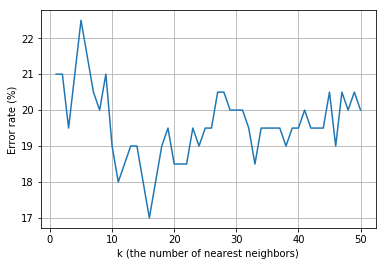

In [16]:
# plot a line chart to show the error rate of different k
plt.plot(range(1, len(error_rate)+1), error_rate*100)

plt.xlabel('k (the number of nearest neighbors)')
plt.ylabel('Error rate (%)')
plt.grid(True)

plt.savefig('error_rate.png', dpi=90)

In [17]:
[test_set_fns[test_indices[i]] for i in range(sample_num)]

['rec.autos\\103780',
 'talk.religion.misc\\84560',
 'misc.forsale\\76818',
 'comp.sys.ibm.pc.hardware\\60983',
 'comp.os.ms-windows.misc\\9945',
 'sci.electronics\\54503',
 'talk.politics.misc\\178940',
 'comp.os.ms-windows.misc\\9827',
 'sci.space\\61494',
 'comp.os.ms-windows.misc\\9576',
 'rec.sport.baseball\\104768',
 'rec.motorcycles\\104669',
 'sci.med\\59371',
 'talk.politics.misc\\178851',
 'sci.electronics\\54304',
 'sci.crypt\\16079',
 'comp.os.ms-windows.misc\\9807',
 'talk.politics.mideast\\76413',
 'sci.space\\61156',
 'misc.forsale\\76840',
 'comp.sys.mac.hardware\\51977',
 'comp.os.ms-windows.misc\\9672',
 'talk.religion.misc\\84351',
 'rec.sport.baseball\\104891',
 'comp.sys.mac.hardware\\52297',
 'comp.graphics\\38717',
 'comp.graphics\\38746',
 'comp.graphics\\39615',
 'sci.space\\61254',
 'misc.forsale\\76391',
 'comp.windows.x\\67431',
 'comp.sys.mac.hardware\\52258',
 'comp.graphics\\39074',
 'comp.sys.ibm.pc.hardware\\60896',
 'rec.autos\\103180',
 'rec.sport.bas

In [19]:
# read the whole testing set
whole_test_docs = []
for fn in test_set_fns:
    with open(PATH+fn, encoding='latin1') as f:
        whole_test_docs.append(f.read())

whole_test_tokenized_docs = []
for doc in whole_test_docs:
    word_tokens = tokenizer.tokenize(doc) # Tokenization
    word_stems = [stemmer.stem(w.lower()) for w in word_tokens] # Stemming/normalization
    word_without_stopwords = filter_stop_words(word_stems) # Stopword/controlled vocabulary filtering
    whole_test_tokenized_docs.append(word_without_stopwords)

In [20]:
# get the VSM representation of whole testing documents
whole_test_vsms = []
for doc in whole_test_tokenized_docs:
    vsm = VectorSpaceModel(doc)
    whole_test_vsms.append(vsm)

for vsm in whole_test_vsms:
    vsm.calWeight(TF_Scale.MAXIMUM)
    vsm.normalize()

In [21]:
# set k = the best k in sampled testing set
k = np.argmin(error_rate)+1
print(k)

16


In [22]:
# classify the whole testing data for the best k
result_for_whole_test_set = []
for vsm in whole_test_vsms:
    result_for_whole_test_set.append(classifier.classify(vsm, k))

In [23]:
# compute the error rate of whole testing data
error_rate = 1
for i, label in enumerate(result_for_whole_test_set):
    if label != os.path.dirname(test_set_fns[i]):
        sum_ += 1

error_rate = sum_/len(test_set_fns)
print("The final error rate is: " + str(error_rate*100) + "%.")

The final error rate is: 20.185772541912097%.
